# Hand Gesture Recognition Notebook

This notebook uses MediaPipe to detect hand landmarks from a webcam feed.

In [ ]:
%pip install -r requirements.txt

## Model Training

This section loads the dataset created in the `data_generation` notebook, splits it into training and testing sets, and then trains a neural network to classify the gestures. The trained model is saved for later use in real-time prediction.

In [2]:
from sklearn.model_selection import train_test_split
from src.gesture_controller.gesture_classifier import GestureClassifier
from src.gesture_controller.app_config import AppConfig
import itertools as itertools
import pandas as pd
import numpy as np
import sys
import os

# Create a default AppConfig instance for training (uses default key_bindings.json)
# The config file path is now relative to the project root
app_config = AppConfig()

# --- Load Configuration ---
model_path = app_config.get_neural_network_config().get('MODEL_PATH')
dataset_path = app_config.get_neural_network_config().get('DATASET_PATH')
hyperparam_config = app_config.get_hyperparameter_config()

# --- Load and Prepare Dataset ---
try:
    df = pd.read_csv(os.path.join('..', dataset_path))

    # Convert the 'LANDMARKS' column from string representation of list to actual list
    df['LANDMARKS'] = df['LANDMARKS'].apply(eval)

    X = np.array(df['LANDMARKS'].tolist())
    Y = df['GESTURE_ID']

    # Dynamically determine number of classes based on highest gesture ID
    max_gesture_id = Y.max()
    num_classes = max_gesture_id + 1

    # Split the data into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # --- Hyperparameter Tuning ---
    hyperparam_keys = list(hyperparam_config.keys())
    hyperparam_values = list(hyperparam_config.values())

    # Generate all combinations
    hyperparam_combinations = list(itertools.product(*hyperparam_values))

    print(f"Total hyperparameter combinations: {len(hyperparam_combinations)}")

    training_history = []
    best_model = None
    best_val_accuracy = 0
    best_val_loss = float('inf')

    # Iterate over all hyperparameter combinations
    for i, params in enumerate(hyperparam_combinations):
        
        hyperparams = dict(zip(hyperparam_keys, params))
        
        print(f"--- Training Variant {i+1}/{len(hyperparam_combinations)} ---")
        print(f"Hyperparameters: {hyperparams}")
        
        # Create a new classifier for each hyperparameter combination
        classifier = GestureClassifier(num_classes=num_classes, input_size=X_train.shape[1], hyperparams=hyperparams)

        # Train the model
        model, history = classifier.train(
            X_train, Y_train, X_val, Y_val, 
            batch_size=hyperparams['BATCH_SIZE'], 
            epochs=hyperparams['EPOCHS']
        )
        
        # Get final validation metrics
        score_val_accuracy = history.history['val_accuracy'][-1]
        score_val_loss = history.history['val_loss'][-1]
        
        # Store history
        run_info = {
            'variant': i + 1,
            'hyperparameters': hyperparams,
            'val_accuracy': score_val_accuracy,
            'val_loss': score_val_loss,
            'history': history.history,
            'model': model
        }
        training_history.append(run_info)
        

    # Display results
    history_df = pd.DataFrame(training_history)
    history_df.to_csv(os.path.join('..', 'models/models_performance.csv'), index=False)

    best_run = min(training_history, key=lambda x: (1 - x['val_accuracy'], x['val_loss']))
    print("Best model found with validation accuracy:", best_run['val_accuracy'], "and validation loss:", best_run['val_loss'])
    best_run['model'].save(os.path.join('..', model_path))


except FileNotFoundError:
    print(f"Error: Dataset file not found at '{os.path.join('..', dataset_path)}'.")
    print("Please run the data generation notebook first.")
except Exception as e:
    print(f"An error occurred: {e}")

AttributeError: 'function' object has no attribute 'get'

## Variant Performance Analysis

This section provides a concise, visual summary of how different hyperparameter configurations impact validation performance. Using the aggregated `history_df` and per-run `training_history`, plots will compare and rank variants to support model selection.

Planned visuals:
- Overview
    - Line/scatter: variant vs. val_accuracy and val_loss (with thresholds)
    - Leaderboard: top-N variants by val_accuracy, tie-broken by val_loss
- Distributions and stability
    - Box/violin plots of val_accuracy and val_loss grouped by:
        - ACTIVATION
        - DROPOUT_RATE
        - LEARNING_RATE
        - BATCH_SIZE
        - DENSE_LAYERS depth/width
- Interactions
    - Faceted scatter: LEARNING_RATE × DROPOUT_RATE, colored by ACTIVATION, sized by BATCH_SIZE
    - Parallel coordinates across hyperparameters with color mapped to val_accuracy
- Learning dynamics
    - Training vs. validation accuracy/loss curves for the best and a few representative variants to inspect generalization gap
- Sensitivity
    - Bar charts of mean val_accuracy by each hyperparameter level with error bars
    - Pairwise comparisons to highlight robust regions of the search space

Outcomes:
- Identify the best-performing and most stable configurations
- Reveal hyperparameter sensitivities and beneficial combinations
- Choose a final model to save to MODEL_PATH and document recommended defaults

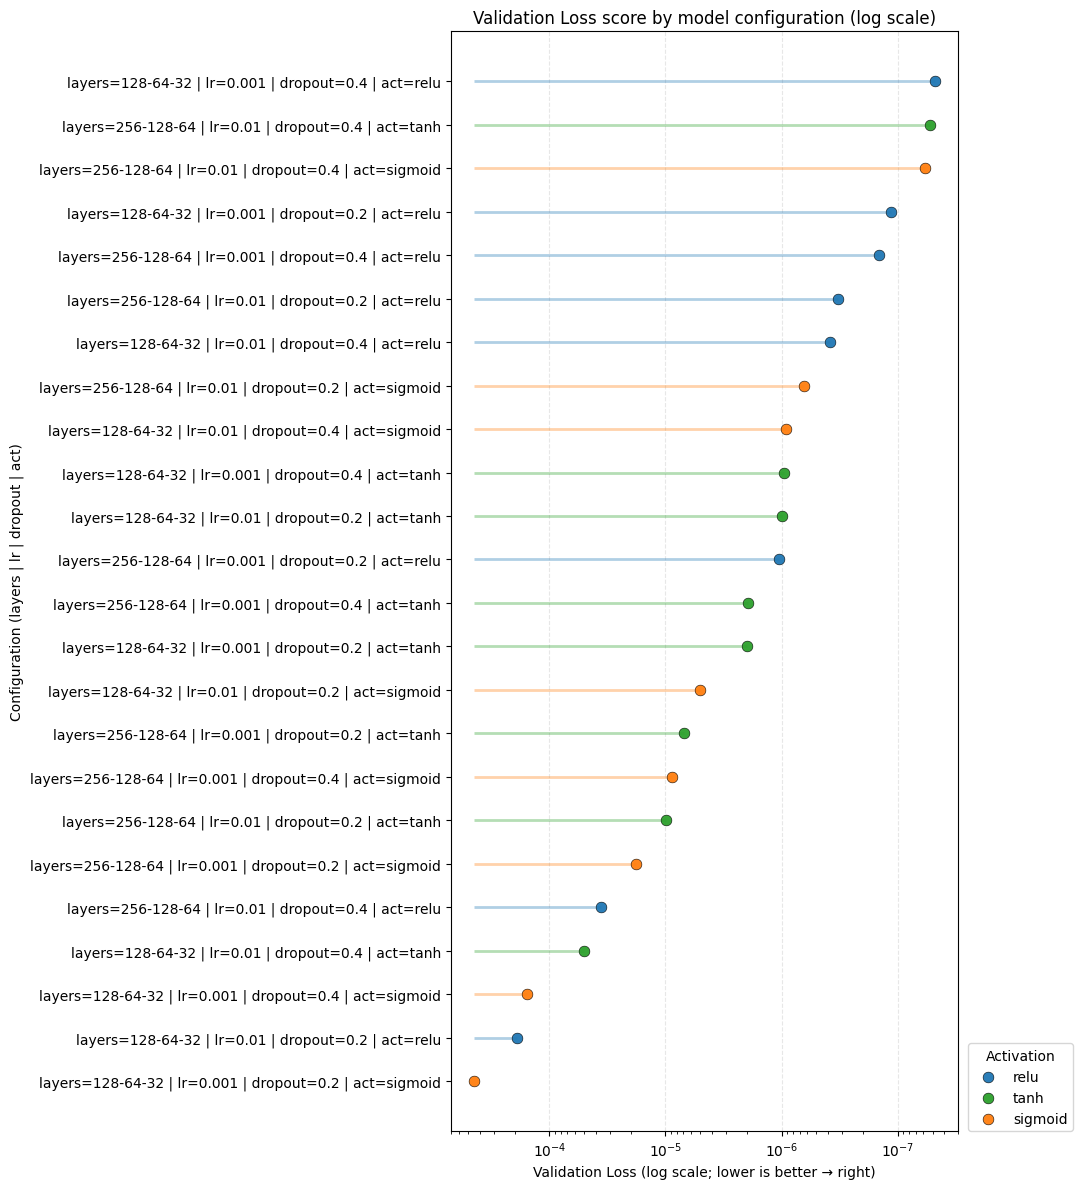

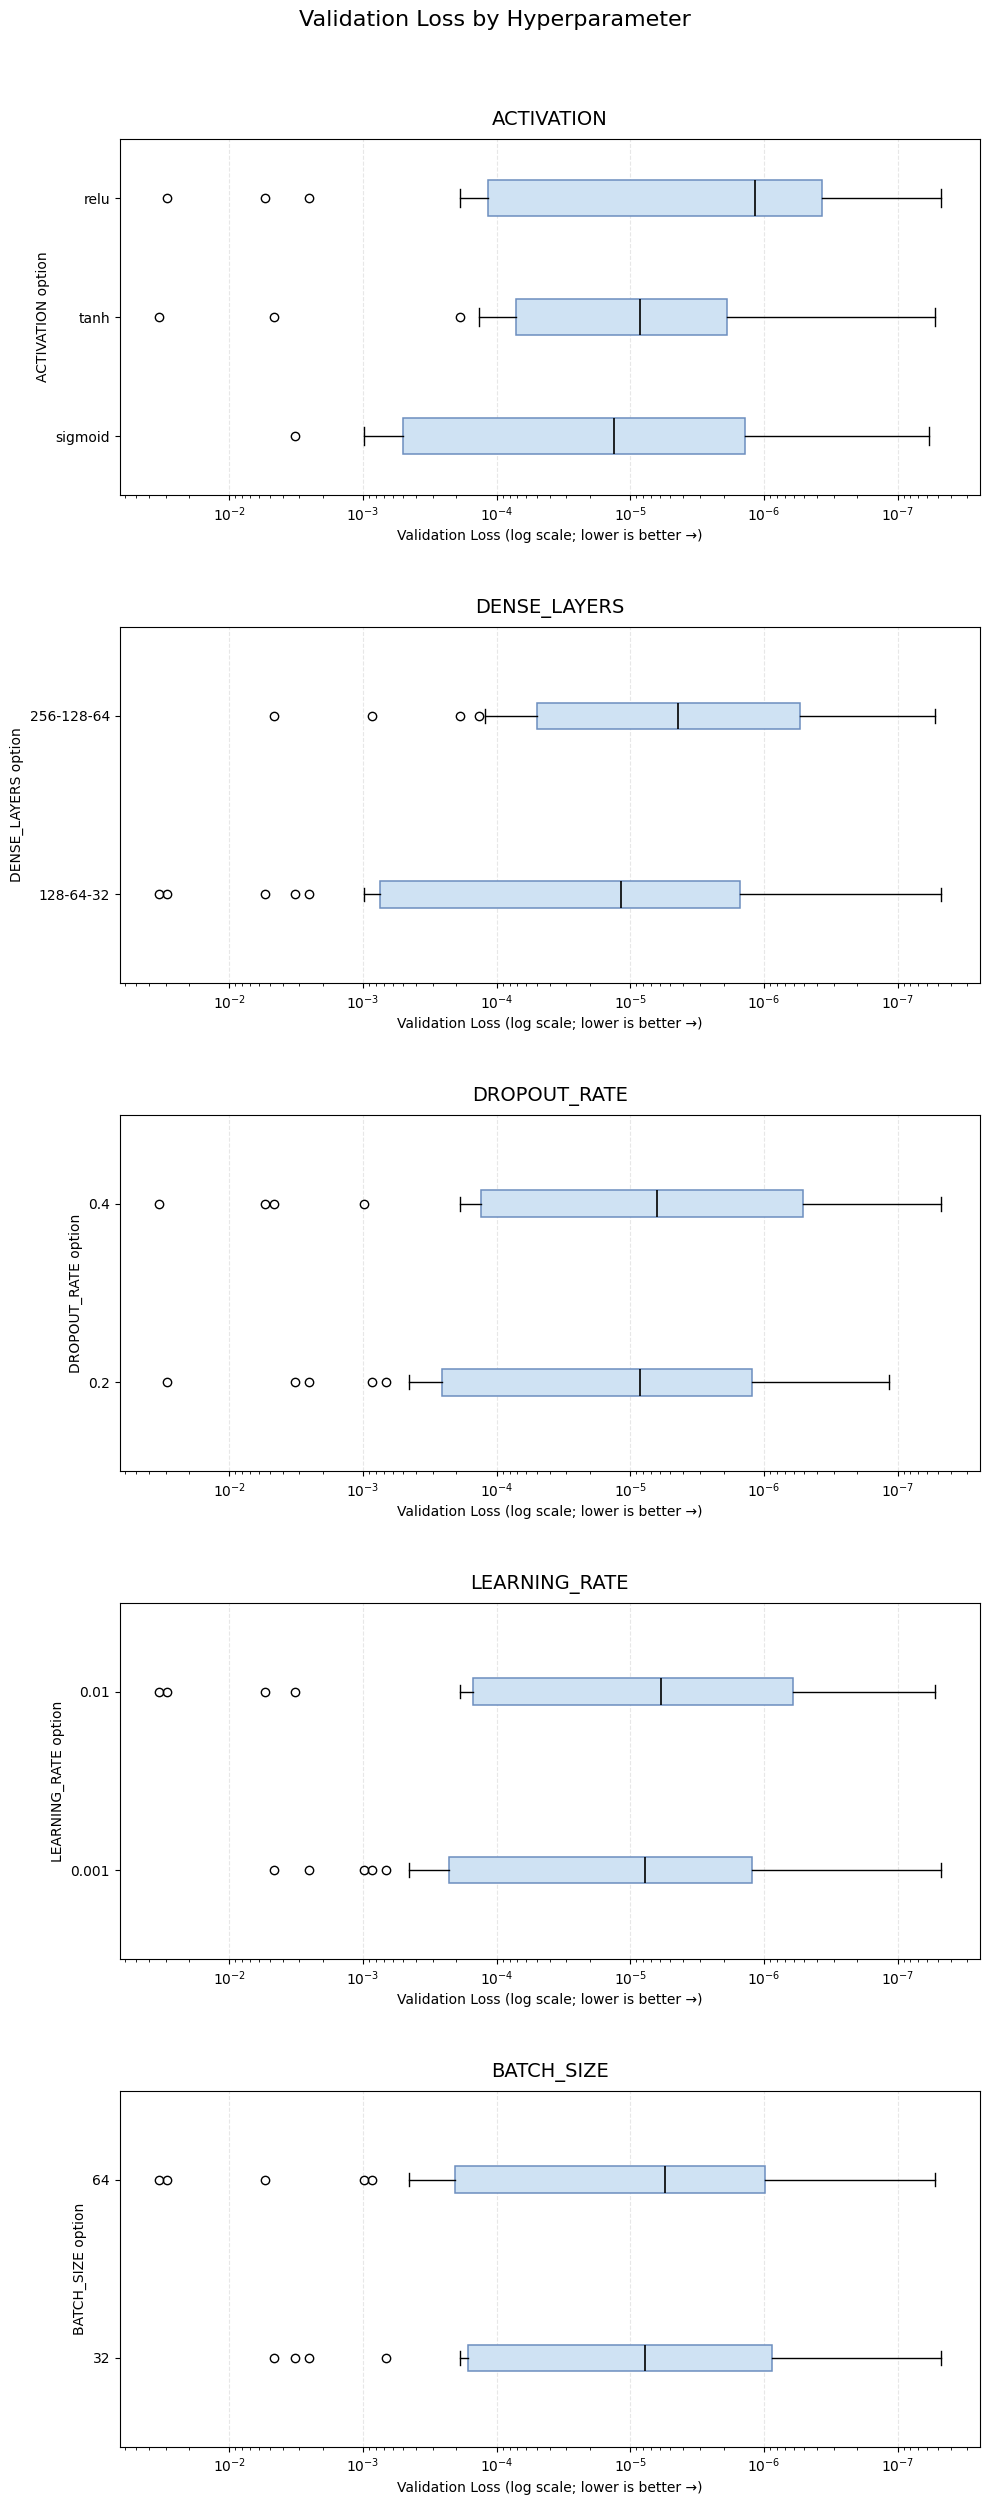

In [5]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
import pandas as pd
import sys
import os

config = AppConfig()
paths = config.get_neural_network_config()
model_performance_path = paths.get('MODEL_PERFORMANCE_PATH')

df = pd.read_csv(model_performance_path)
plot_helper = PlotHelper()
plot_helper.plot_model_val_loss_score(df)
plot_helper.plot_val_loss_by_parameter(df)

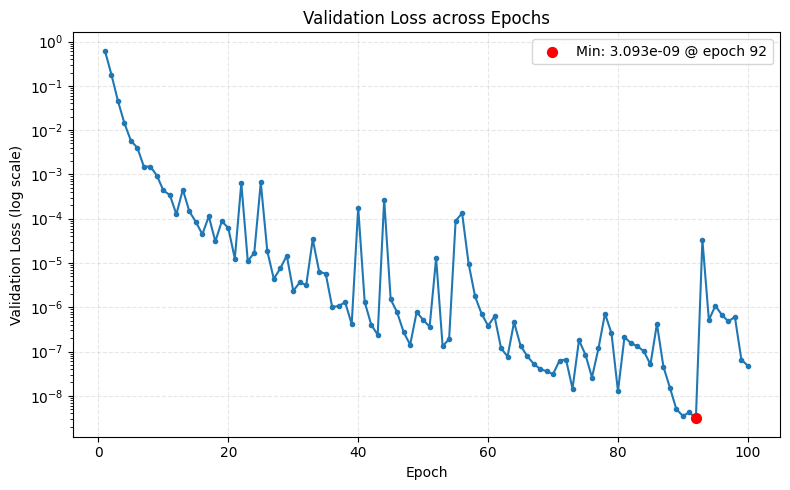

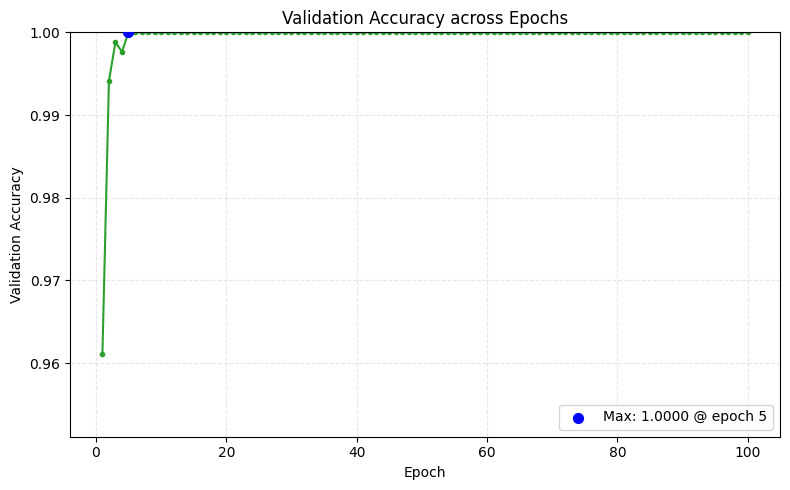

FileNotFoundError: [Errno 2] No such file or directory: '../data/gestures_dataset.csv'

In [ ]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os

# Resolve paths from config
config = AppConfig()
paths = config.get_neural_network_config()
dataset_path = os.path.join('..', paths.get('DATASET_PATH'))
model_path = os.path.join('..', paths.get('MODEL_PATH'))
model_performance_path = os.path.join('..', paths.get('MODEL_PERFORMANCE_PATH'))


df = pd.read_csv(model_performance_path)
winner = df.sort_values(by=['val_accuracy', 'val_loss'], ascending=[False, True]).iloc[0]
plot_helper = PlotHelper()
plot_helper.plot_val_loss_in_epochs(winner)
plot_helper.plot_val_accuracy_in_epochs(winner)


# Load dataset
df = pd.read_csv(dataset_path)
df['LANDMARKS'] = df['LANDMARKS'].apply(eval)
X = np.array(df['LANDMARKS'].tolist())
Y = df['GESTURE_ID'].to_numpy()

# Train/val split (same seed as training)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Load model and predict
model = tf.keras.models.load_model(model_path)
probs = model.predict(X_val, verbose=0)
y_pred = np.argmax(probs, axis=1)

# Confusion matrix plot
classes = np.unique(Y)
plot_helper.plot_heatmap(Y_val, y_pred, classes)

# ROC plot
plot_helper.plot_roc_curve(Y_val, probs, classes)

# PCA Visualization plot
plot_helper.plot_pca(X_val, y_pred)

# t-SNE Visualization plot
plot_helper.plot_tsne(X_val, y_pred)